In [171]:
# setup & utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def peek(df,n=5,describe=False,title=''):
  if title:
    print(title)
  n_rows = min(n,len(df.index))
  print('%s rows:\n%s'%(n_rows, df.sample(n_rows).sort_index()))
  if describe:
    print(df.describe(include='all'))
def uniq(df,ks):
  for k in ks:
    print('uniq: %s: %s'%(k, df[k].unique()))

In [185]:
# import & sample
df_raw = pd.read_csv('4705_center.csv')
peek(df_raw,5,True)
uniq(df_raw, ('Beds','Baths'))

5 rows:
         Date   Unit    Rent   Beds    Baths     ft_
76    11/6/19  #2204  $3,483  1 bed   1 bath   766.0
645    5/5/15  #2003  $3,250  1 bed   1 bath     NaN
1221  7/27/11  #2010  $2,650  1 bed   1 bath     NaN
1356   4/8/11  #4101  $3,560  1 bed  2 baths  1233.0
1614  7/16/10  #7109  $2,595  1 bed   1 bath   771.0
           Date   Unit    Rent   Beds   Baths          ft_
count      1750   1750    1750   1750    1749   866.000000
unique      781    790     375      4       4          NaN
top     5/26/11  #2803  $2,850  1 bed  1 bath          NaN
freq         17      9      57   1226    1355          NaN
mean        NaN    NaN     NaN    NaN     NaN   826.974596
std         NaN    NaN     NaN    NaN     NaN   219.584551
min         NaN    NaN     NaN    NaN     NaN   512.000000
25%         NaN    NaN     NaN    NaN     NaN   713.000000
50%         NaN    NaN     NaN    NaN     NaN   738.000000
75%         NaN    NaN     NaN    NaN     NaN  1098.750000
max         NaN    NaN   

In [194]:
# parse & clean
df = (pd.DataFrame()
  .assign(date=pd.to_datetime(df_raw['Date'], format='%m/%d/%y'))
  .assign(rent=df_raw['Rent']
    .replace('[\$,]','',regex=True)
    .astype(float))
  .assign(unit=df_raw['Unit']
    .replace('[#A\-SC]','',regex=True))
  .assign(beds=df_raw['Beds']
    .fillna('0')
    .apply(lambda s:s[0])
    .replace('s','0')
    .astype(int))
  .assign(baths=df_raw['Baths']
    .fillna('0')
    .apply(lambda s:s[0])
    .astype(int))
  .assign(area=pd.to_numeric(df_raw['ft_'], errors='coerce')
    .fillna(0.)) # already float
  )

df = df[df.date>'2011/07/08']  # drop differently-unit-labelled data before 2011.07.08
df = df[df.beds<3]  # drop mis-labelled, non-existent "3 beds"

""" cleanup wrong labels via majority vote """
def find_mislabelled_units(df, k='beds'):
  df_check = (df
    .groupby('unit')
    [k]
    .agg(['count','mean']))
  df_check = df_check.assign(beds=df_check['mean'].round(0))
  df_fix = df_check[df_check['mean']%1>TOLERANCE]
  peek(df_fix,100)
  return df_fix
def fix_mislabel(df, df_fix, k='beds'):
  for idx, row in df_fix.iterrows():
    df.loc[df['unit']==idx, k] = row.to_dict()[k]

df_fix = find_mislabelled_units(df, k='beds')
fix_mislabel(df, df_fix, k='beds')
assert find_mislabelled_units(df, k='beds').empty
peek(df,3,True)

10 rows:
      count      mean  beds
unit                       
1202      9  0.222222   0.0
1702      5  0.400000   0.0
1907      3  1.333333   1.0
2207      7  1.142857   1.0
2305      4  1.250000   1.0
2306      6  0.833333   1.0
2401      5  1.800000   2.0
401       4  0.250000   0.0
506       5  0.800000   1.0
801       5  0.400000   0.0
0 rows:
Empty DataFrame
Columns: [count, mean, beds]
Index: []
3 rows:
           date    rent  unit  beds  baths   area
832  2013-11-12  3055.0   804   1.0      1  840.0
981  2012-11-20  2965.0  2604   1.0      1  766.0
1110 2012-03-02  2670.0  1410   1.0      1    0.0
                       date         rent  unit         beds        baths         area
count                  1220  1220.000000  1220  1220.000000  1220.000000  1220.000000
unique                  698          NaN   401          NaN          NaN          NaN
top     2016-08-12 00:00:00          NaN  1202          NaN          NaN          NaN
freq                     15          NaN

In [195]:
""" Convert price_net to price_gross
  assume non-multiples-of-100 are result of x*12/13
  consider guess correct if result within 5% of multiple-of-100
  """
TICK = 50
TOLERANCE = 0.05
GUESS_FAILED = 0
FACTORS_CONCESSION = [(13,12), (14,12), (12,11)]

def near_tick(price, tick, tol):  return price%tick/tick <= tol

def guess_concession(price_net, factor, tick, tol):
  numer, denom = factor
  price_gross_estimate = int(price_net * numer / denom)
#   print(price_gross_estimate)
  pct_excess = price_gross_estimate%tick/tick
#   print(pct_excess)
  err = min(pct_excess, 1-pct_excess)
  if err<=tol:
    adjustment = -pct_excess if err==pct_excess else 1-pct_excess
#     print(adjustment)
    price_gross = price_gross_estimate + adjustment*tick
#     print('%s -%s> %s'%(price_net, factor, price_gross))
    return price_gross
  
  return GUESS_FAILED

def net2gross(price_net, tick=TICK, tol=TOLERANCE):
  if not near_tick(price_net, tick, tol):
    for factor in FACTORS_CONCESSION:
      result = guess_concession(price_net, factor, tick, tol)
      if result != GUESS_FAILED:
        return result
#     print('? %s'%price_net)
  return price_net

assert net2gross(5077)==5500
assert net2gross(3323)==3600
assert net2gross(2950)==2950
assert net2gross(3831)==4150

df = df.assign(rent_gross=df['rent'].apply(net2gross))
peek(df,5,True)

5 rows:
           date    rent  unit  beds  baths   area  rent_gross
153  2019-04-05  3231.0   413   1.0      1  653.0      3500.0
174  2019-03-02  3415.0  1713   1.0      1  765.0      3700.0
254  2018-07-17  2725.0  2102   0.0      1    0.0      2950.0
695  2015-01-03  3150.0  2904   1.0      1    0.0      3150.0
1110 2012-03-02  2670.0  1410   1.0      1    0.0      2670.0
                       date         rent  unit         beds        baths         area   rent_gross
count                  1220  1220.000000  1220  1220.000000  1220.000000  1220.000000  1220.000000
unique                  698          NaN   401          NaN          NaN          NaN          NaN
top     2016-08-12 00:00:00          NaN  1202          NaN          NaN          NaN          NaN
freq                     15          NaN     9          NaN          NaN          NaN          NaN
first   2011-07-15 00:00:00          NaN   NaN          NaN          NaN          NaN          NaN
last    2020-07-15 00:00:0

In [196]:
""" Normalize unit-price by floor/line 
  ? iterative-register line-area in dict to infer un-labelled ones
  """
def norm_price(price_nominal):
  
  return price_normalized

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


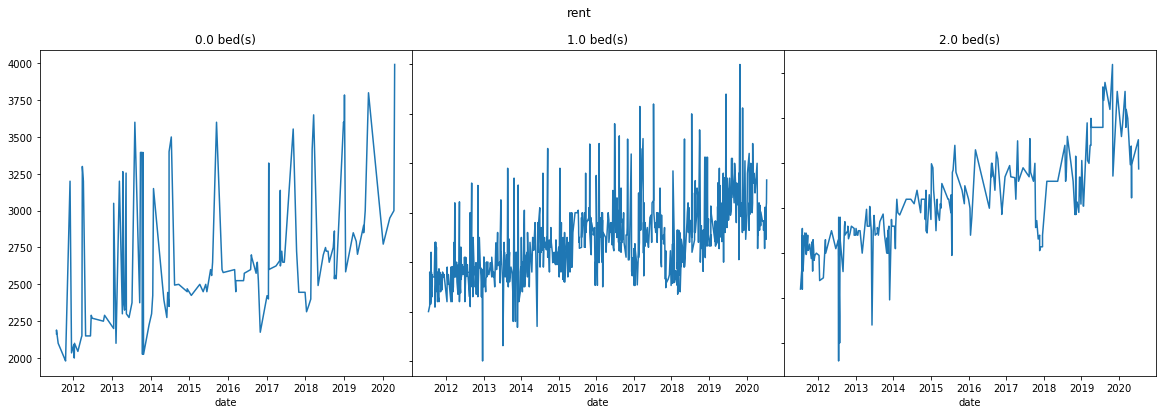

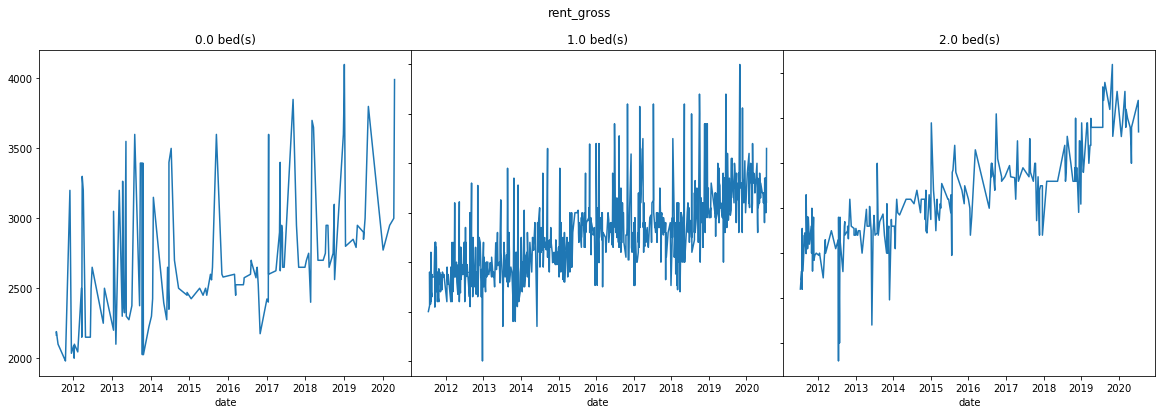

In [197]:
# viz: by type, over time
def groupby_plot(df, ks_group, kx, ky, **kwargs):
  df_groups = (df
    .groupby(ks_group)
    [kx, ky]
#     .transform(lambda x:x.rolling(10,1).mean())
    )
  fig, axes = plt.subplots(nrows=1,ncols=len(df_groups),figsize=(20,6))
  for i, (n_bed, group) in enumerate(df.groupby(ks_group)):
    group.plot(x=kx, y=ky,
      subplots=True,
      ax=axes[i],
      sharey=True,
      legend=False,
      **kwargs)
    axes[i].set_title('%s bed(s)'%n_bed)

  fig.subplots_adjust(hspace=0, wspace=0)
  fig.suptitle(ky)
  plt.show()
    
groupby_plot(df,ks_group='beds',kx='date',ky='rent')
groupby_plot(df,ks_group='beds',kx='date',ky='rent_gross')

In [198]:
peek(df[(df['beds']==2) & (df['date'].dt.year==2020)],50)

13 rows:
         date    rent  unit  beds  baths    area  rent_gross
5  2020-07-09  4938.0  2501   2.0      2  1100.0      5350.0
7  2020-07-07  5077.0  1508   2.0      2  1196.0      5500.0
8  2020-07-06  5262.0  1514   2.0      2  1203.0      5700.0
22 2020-05-02  4985.0  2709   2.0      2  1162.0      5400.0
23 2020-05-01  4615.0  1201   2.0      2  1100.0      5000.0
24 2020-04-28  5192.0  1609   2.0      2  1162.0      5192.0
29 2020-04-19  4985.0  1409   2.0      2  1162.0      5400.0
33 2020-03-25  5500.0  1208   2.0      2  1196.0      5500.0
37 2020-03-10  5600.0  2514   2.0      2  1203.0      5600.0
40 2020-03-07  5400.0  2214   2.0      2  1203.0      5400.0
44 2020-02-28  5800.0  3001   2.0      2  1100.0      5800.0
49 2020-02-05  5450.0  2901   2.0      2  1100.0      5450.0
58 2020-01-24  5298.0  2201   2.0      2  1100.0      5298.0


In [ ]:
#? lengths of stay